In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import  KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### <center> Перекрестная проверка модели (cross-validation)

**Перекрестная проверка** - статистический метод оценки обобщающей способности модели. Он более устойчив к ошибкам, чем разбиение данных на обучающий и тестовый наборы.

**Идея:** давайте разобьем данные на несколько частей/блоков/фолдов, построим модель несколько раз на разных частях данных и посмотрим, насколько хорошо и устойчиво работает модель. Такая проверка называется **k-блочной кросс-проверкой (k-fold cross-validation)**.



<img src='https://github.com/MalikaL17/course_materials/blob/main/img/k-fold%20cross-val.PNG?raw=true'>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('drive/My Drive/Курс по анализу данных/Магистры 1 курс/Нормализация данных/data_house_prices_2_clean.xlsx')
df.head()

,Price,Area,YearBuilt,YearRestoration,MasVnrArea,RoomsNumb,SchoollDistance,CenterDistance
0,380000,8450,2003,2003,196,8,2996.0,20081
1,181500,9600,1976,1976,0,6,7606.0,15171
2,223500,11250,2001,2002,162,6,5856.0,17368
3,140000,9550,1915,1970,0,7,4789.0,21808
4,250000,14260,2000,2000,350,9,1248.0,16240


In [ ]:
X = df[['Area',	'YearBuilt',	'YearRestoration',	'MasVnrArea',	'RoomsNumb',	'SchoollDistance', 'CenterDistance']]
y = df['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = KNeighborsRegressor()
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

print('MAE train: ', mean_absolute_error(y_train, pred_train))
print('MAE test: ', mean_absolute_error(y_test, pred_test))

MAE train:  44243.875
MAE test:  67183.98000000001


In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
reg = KNeighborsRegressor()
scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_absolute_error') #neg_mean_squared_error 
print("Значения точности при перекрестной проверке: \n{}".format(scores))

Значения точности при перекрестной проверке: 
[-41739.08 -69274.86 -72127.3  -63364.14 -37139.64]


Чаще всего полученные значения усредняют и ориентрируются по средней. Можно так же посмотреть на стандартное отклонение - чем оно меньше, тем устойчивее результат

In [ ]:
print("Среднее значение перекрестной проверки: {:.2f} \nStd: {:.3f}".format(scores.mean(), scores.std()))

Среднее значение перекрестной проверки: -56729.00 
Std: 14470.467


Можно воспользоваться перемешиванием и передавать этот метод в качестве параметра **cv** в кросс-валидацию. 

Возможны два варианта: с перемешиванием (**shufle=True** и без **shufle=False**)

**Луше делать с перемешиванием!**

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

In [ ]:
scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_absolute_error') #neg_mean_squared_error 
print("Значения точности при перекрестной проверке: \n{}".format(scores))
print('_'*50)
print("Среднее значение перекрестной проверки: {:.2f} \nStd: {:.3f}".format(scores.mean(), scores.std()))

Значения точности при перекрестной проверке: 
[-55035.8  -37899.86 -48199.14 -75691.34 -64774.58]
__________________________________________________
Среднее значение перекрестной проверки: -56320.14 
Std: 13066.199


### <center> Подбор оптимальных гиперпараметров модели

Что, если мы хотим определять оптимальные гиперпараметры дерева автоматически? 

Для этого в sklearn-е специальные инструменты - **GridSearch** и **RandomSearch**

- **GridSearch** - ищет оптимальные гиперпараметры из значений "сетки", которую мы ему задали
- **RandomSearch** - ищет оптимальные гиперпараметры из случайных значений в заданном распределении

Рассмотрим на примере поиска оптимальных гиперпараметров для дерева регрессии

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
# создаем объект модели, которую хотим тюнить
reg = KNeighborsRegressor()

# задаем словарь с сеткой значений гиперпапаметров
param_grid = {'n_neighbors': [i for i in range(1, 30, 1)],
              'weights':['uniform', 'distance']}

# создаем объект GridSearchCV, передаем ему объект модели и сетку параметров для поиска
grid_search = GridSearchCV(reg, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error')
# ищем оптимальные параметры 
grid_search.fit(X, y)

# summarize resultv
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)

Best Score: -54681.009999999995
Best Hyperparameters: {'n_neighbors': 16, 'weights': 'uniform'}


Построим модель с оптимальными параметрами и посмотрим ее качество на кросс-проверке

In [ ]:
reg = KNeighborsRegressor(n_neighbors=16, weights='uniform')
scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_absolute_error') #neg_mean_squared_error 

print("Значения точности при перекрестной проверке: \n{}".format(scores))
print('_'*50)
print("Среднее значение перекрестной проверки: {:.2f} \nStd: {:.3f}".format(scores.mean(), scores.std()))

Значения точности при перекрестной проверке: 
[-61878.39375 -44655.75    -35994.61875 -69955.01875 -60921.26875]
__________________________________________________
Среднее значение перекрестной проверки: -54681.01 
Std: 12439.659


:Посмотрим на кривую точности модели в зависимости от параметров

Оптимальное число соседей: 16. Достигается MAE: 54681.009999999995
CPU times: user 1.01 s, sys: 2.48 ms, total: 1.01 s
Wall time: 1.06 s


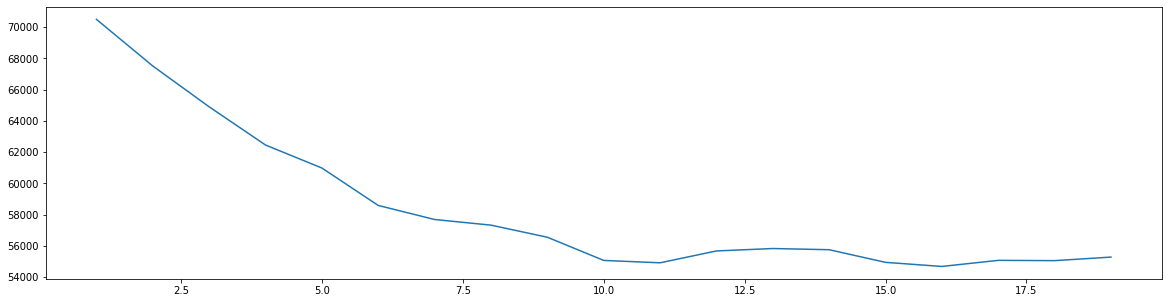

In [ ]:
%%time
plt.figure(figsize=(20, 5))
n_neighbors_list, score = [], []
for n in range(1,20):
    n_neighbors_list.append(n)
    reg = KNeighborsRegressor(n_neighbors=n)
    mean_mae = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_absolute_error').mean()
    score.append(-mean_mae)

print(f"Оптимальное число соседей: {score.index(min(score)) + 1}. Достигается MAE: {score[score.index(min(score))]}")
plt.plot(n_neighbors_list, score);

**RandomSearch**

In [ ]:
# создаем объект модели, которую хотим тюнить
reg = KNeighborsRegressor()

param_distributions = {'n_neighbors': [i for i in range(1, 30, 1)],
              'weights':['uniform', 'distance']}
random_search = RandomizedSearchCV(reg, param_distributions = param_distributions, n_iter=15, random_state=0,
                                   scoring='neg_mean_squared_error')
# ищем оптимальные параметры 
random_search.fit(X, y)

print('Best Score: %s' % random_search.best_score_)
print('Best Hyperparameters: %s' % random_search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 58 is smaller than n_iter=100. Running 58 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best Score: -5997700217.161973
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 12}


### <center> Использование конвееров (Pipeline)

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.datasets import load_wine
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# данные для классификации, 3 класса
data_wine = load_wine()
wine_target = data_wine.target
wine_data = data_wine.data
wine_feature_names = data_wine.feature_names

df = pd.DataFrame(data= np.c_[data_wine['data'], data_wine['target']],
                     columns= data_wine['feature_names'] + ['target'])

In [ ]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [ ]:
# Создать стандартизатор
standardizer = RobustScaler()
# Создать классификатор
lr = LogisticRegression()
# Создать конвейер
pipeline = make_pipeline(standardizer, lr)
# Создать k-блочную перекрестную проверку
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
features = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 
            'nonflavanoid_phenols','proanthocyanins', 'color_intensity', 'hue','od280/od315_of_diluted_wines', 'proline']

X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], 
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
# Выполнить k-блочную перекрестную проверку
cv_results = cross_val_score(pipeline, # Конвейер
                             X_train, # Матрица признаков
                             y_train, # Вектор целей
                             cv=kf, # Метод перекрестной проверки
                             scoring='accuracy', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU

In [ ]:
cv_results

array([0.96, 1.  , 1.  , 0.92, 1.  ])

In [ ]:
pipeline.fit(X_train, y_train)
predict = pipeline.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      0.95      0.98        21
         2.0       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



### Pipeline с GridSearch для подбора лучшей модели

In [ ]:
%%time
# Создать конвейер
pipe = Pipeline([("classifier", KNeighborsClassifier())])
# Создать словарь вариантов обучающихся алгоритмов и их гиперпараметров
search_space = [{"classifier": [LogisticRegression()],
                 "classifier__penalty": ['11', '12'],
                 "classifier__C": np.logspace(0, 4, 10)},
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": [3, 6, 15, 30],
                 "classifier__weights":['uniform', 'distance']}]
# Создать объект решеточного поиска
gridsearch = RandomizedSearchCV(pipe, search_space, cv=3, verbose=1, n_iter=100)
# Выполнить подгонку объекта решеточного поиска
best_model = gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 28 is smaller than n_iter=100. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 28 candidates, totalling 84 fits
CPU times: user 544 ms, sys: 6.02 ms, total: 550 ms
Wall time: 567 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 84.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

In [ ]:
np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [ ]:
best_model.best_estimator_

Pipeline(steps=[('classifier',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [ ]:
best_model.best_score_

0.7022841656987998

In [ ]:
prediction = best_model.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      0.95      0.98        21
         2.0       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

